In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython import nominal
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, lasso_path
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
import statsmodels.api as smf
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None )

In [2]:
df_descr = pd.read_excel('Задание (пролонгация).xlsx')

In [3]:
df = pd.read_excel('Задание (пролонгация).xlsx', sheet_name = 'data_full', index_col='ID')

#### Исследование

In [40]:
df_descr

,id,ID договора
0,Filial,Филиал продажи
1,Type_ts,Тип ТС
2,passport_region,Регион по серии паспорта
3,VIP,VIP клиент
4,Brand,Марка ТС
5,Model,Модель ТС
6,Yr_production,Год выпуска ТС
7,GAP,GAP застрахован
8,married,Брак
9,KBM,КБМ


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10863 entries, 1 to 10863
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Filial           10863 non-null  object 
 1   Type_ts          10863 non-null  object 
 2   passport_region  10863 non-null  object 
 3   VIP              284 non-null    object 
 4   Brand            10863 non-null  object 
 5   Model            10863 non-null  object 
 6   Yr_production    10863 non-null  int64  
 7   GAP              10863 non-null  object 
 8   married          10863 non-null  object 
 9   KBM              10863 non-null  int64  
 10  KBM_prol_est     10863 non-null  int64  
 11  delta_kbm        10863 non-null  int64  
 12  deduct           10863 non-null  object 
 13  deduct_amount    10863 non-null  object 
 14  product          10863 non-null  object 
 15  Bank             10863 non-null  object 
 16  channel - map    10863 non-null  object 
 17  category    

In [326]:
df.head(2)

,Filial,passport_region,VIP,Brand,Model,GAP,married,KBM,KBM_prol_est,deduct,deduct_amount,product,Bank,channel - map,category,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
ID,,,,,,,,,,,,,,,,,,,,,,,,,
1,Магнитогорский,Челябинская область,nan,TOYOTA,RAV 4,Нет,Состоит в браке,0.666667,0.6,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,0.000000,0.380952,0.50,0.466667,M,0,0.75,0.4,0,0
2,Магнитогорский,Челябинская область,nan,LADA,GRANTA,Нет,Состоит в браке,0.666667,0.6,Без франшизы,0,Компакт,Банк,Автосалоны,RN,0.222222,0.063492,0.75,0.066667,M,0,0.00,0.1,0,0


In [274]:
# проверяем наличие повторяющихся строк
df[df.duplicated()].shape

(35, 29)

In [5]:
#Проверяем количество NaN
temp=pd.DataFrame(df.isna().sum(),columns=(['number']))
temp2=temp[temp['number']>0]                
temp2.sort_values(['number'],ascending=False)

,number
VIP,10547


In [123]:
df_train_temp = df[df['target'] != -1].copy()

In [760]:
# Количество значений в разных категориях
temp=pd.DataFrame(df.nunique(), columns = ['number']).T
temp

,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
number,22,2,85,2,23,200,10,2,2,13,11,6,3,3,4,3,2,4,2,67,57,5,16,3,2,13,21,2,3


In [757]:
# Количество значений в разных категориях
temp=pd.DataFrame(df_train_temp.nunique(), columns = ['number']).T
temp

,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,KBM_prol_est,delta_kbm,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target,log_price_prc,log_age,log_amount_gr,log_exp,log_car_age,log_price_gr
number,22,2,85,2,23,190,10,2,2,13,11,6,3,3,4,3,2,4,2,65,57,5,16,3,2,13,21,2,2,21,65,16,57,10,13


In [17]:
mlist = df_train_temp['Model'].to_list()
mlist_ = set([i for i in df['Model'] if i not in mlist])
mlist_
df[df['Model'].isin(mlist_)][['Brand', 'Model']]

,Brand,Model
ID,,
8027,AUDI,A4 ALLROAD
8475,RENAULT,DOKKER
8539,LADA,2111
8694,LADA,1119
9226,RENAULT,DOKKER
9296,VOLKSWAGEN,AMAROK
9360,CHEVROLET,TRAILBLAZER
9672,MITSUBISHI,L-200
9692,PORSCHE,PANAMERA


In [32]:
df_train_temp[df_train_temp['Brand']=='BMW']['Model'].unique()

array(['X6', 'X1', 'X3', 'X5', 'X4', '3-СЕРИЯ', '1-СЕРИЯ', '4-СЕРИЯ',
       '5-СЕРИЯ', 'X5 M', '6-СЕРИЯ'], dtype=object)

In [40]:
models_dict = {'A4 ALLROAD':'A4', 2111:'2170', 1119: '2115', 'DOKKER':'DUSTER', 'AMAROK':'TIGUAN', \
               'TRAILBLAZER':'CAPTIVA', 'L-200':'OUTLANDER', 'PANAMERA':'MACAN', 'PASSAT CC':'PASSAT', '7-СЕРИЯ':'6-СЕРИЯ'}

In [281]:
#Баланс классов
df[['target']].groupby('target').value_counts()

target
-1    3265
 0    5226
 1    2372
dtype: int64

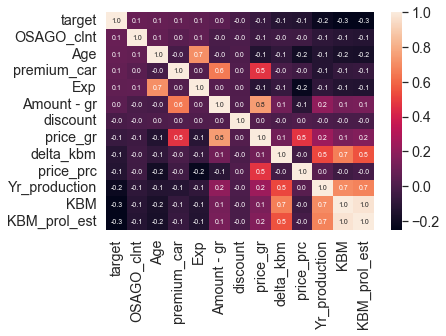

In [174]:
#Матрица корреляции
corrmat = df_train_temp.corr()
k = 30 #количество колонок
cols = corrmat.nlargest(k, 'target')['target'].index
cm = np.corrcoef(df_train_temp[cols].values.T)
sns.set(font_scale=1.3)
hm = sns.heatmap(cm, cbar=True, annot=True, square=False, fmt='.1f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [124]:
for i in df_train_temp[['Model','deduct_amount']]:
    df_train_temp[i] = [str(i) for i in df_train_temp[i]]

In [125]:
df_train_temp['log_price_prc'] = [np.sqrt(i) for i in df_train_temp['price_prc']]
df_train_temp['log_price_gr'] = [np.sqrt(i) for i in df_train_temp['price_gr']]
df_train_temp['log_age'] = [np.log(i) for i in df_train_temp['Age']]
df_train_temp['log_amount_gr'] = [np.sqrt(i) for i in df_train_temp['Amount - gr']]
df_train_temp['log_exp'] = [np.sqrt(i) for i in df_train_temp['Exp']]
df_train_temp['log_car_age'] = [np.log(2022-i) for i in df_train_temp['Yr_production']]

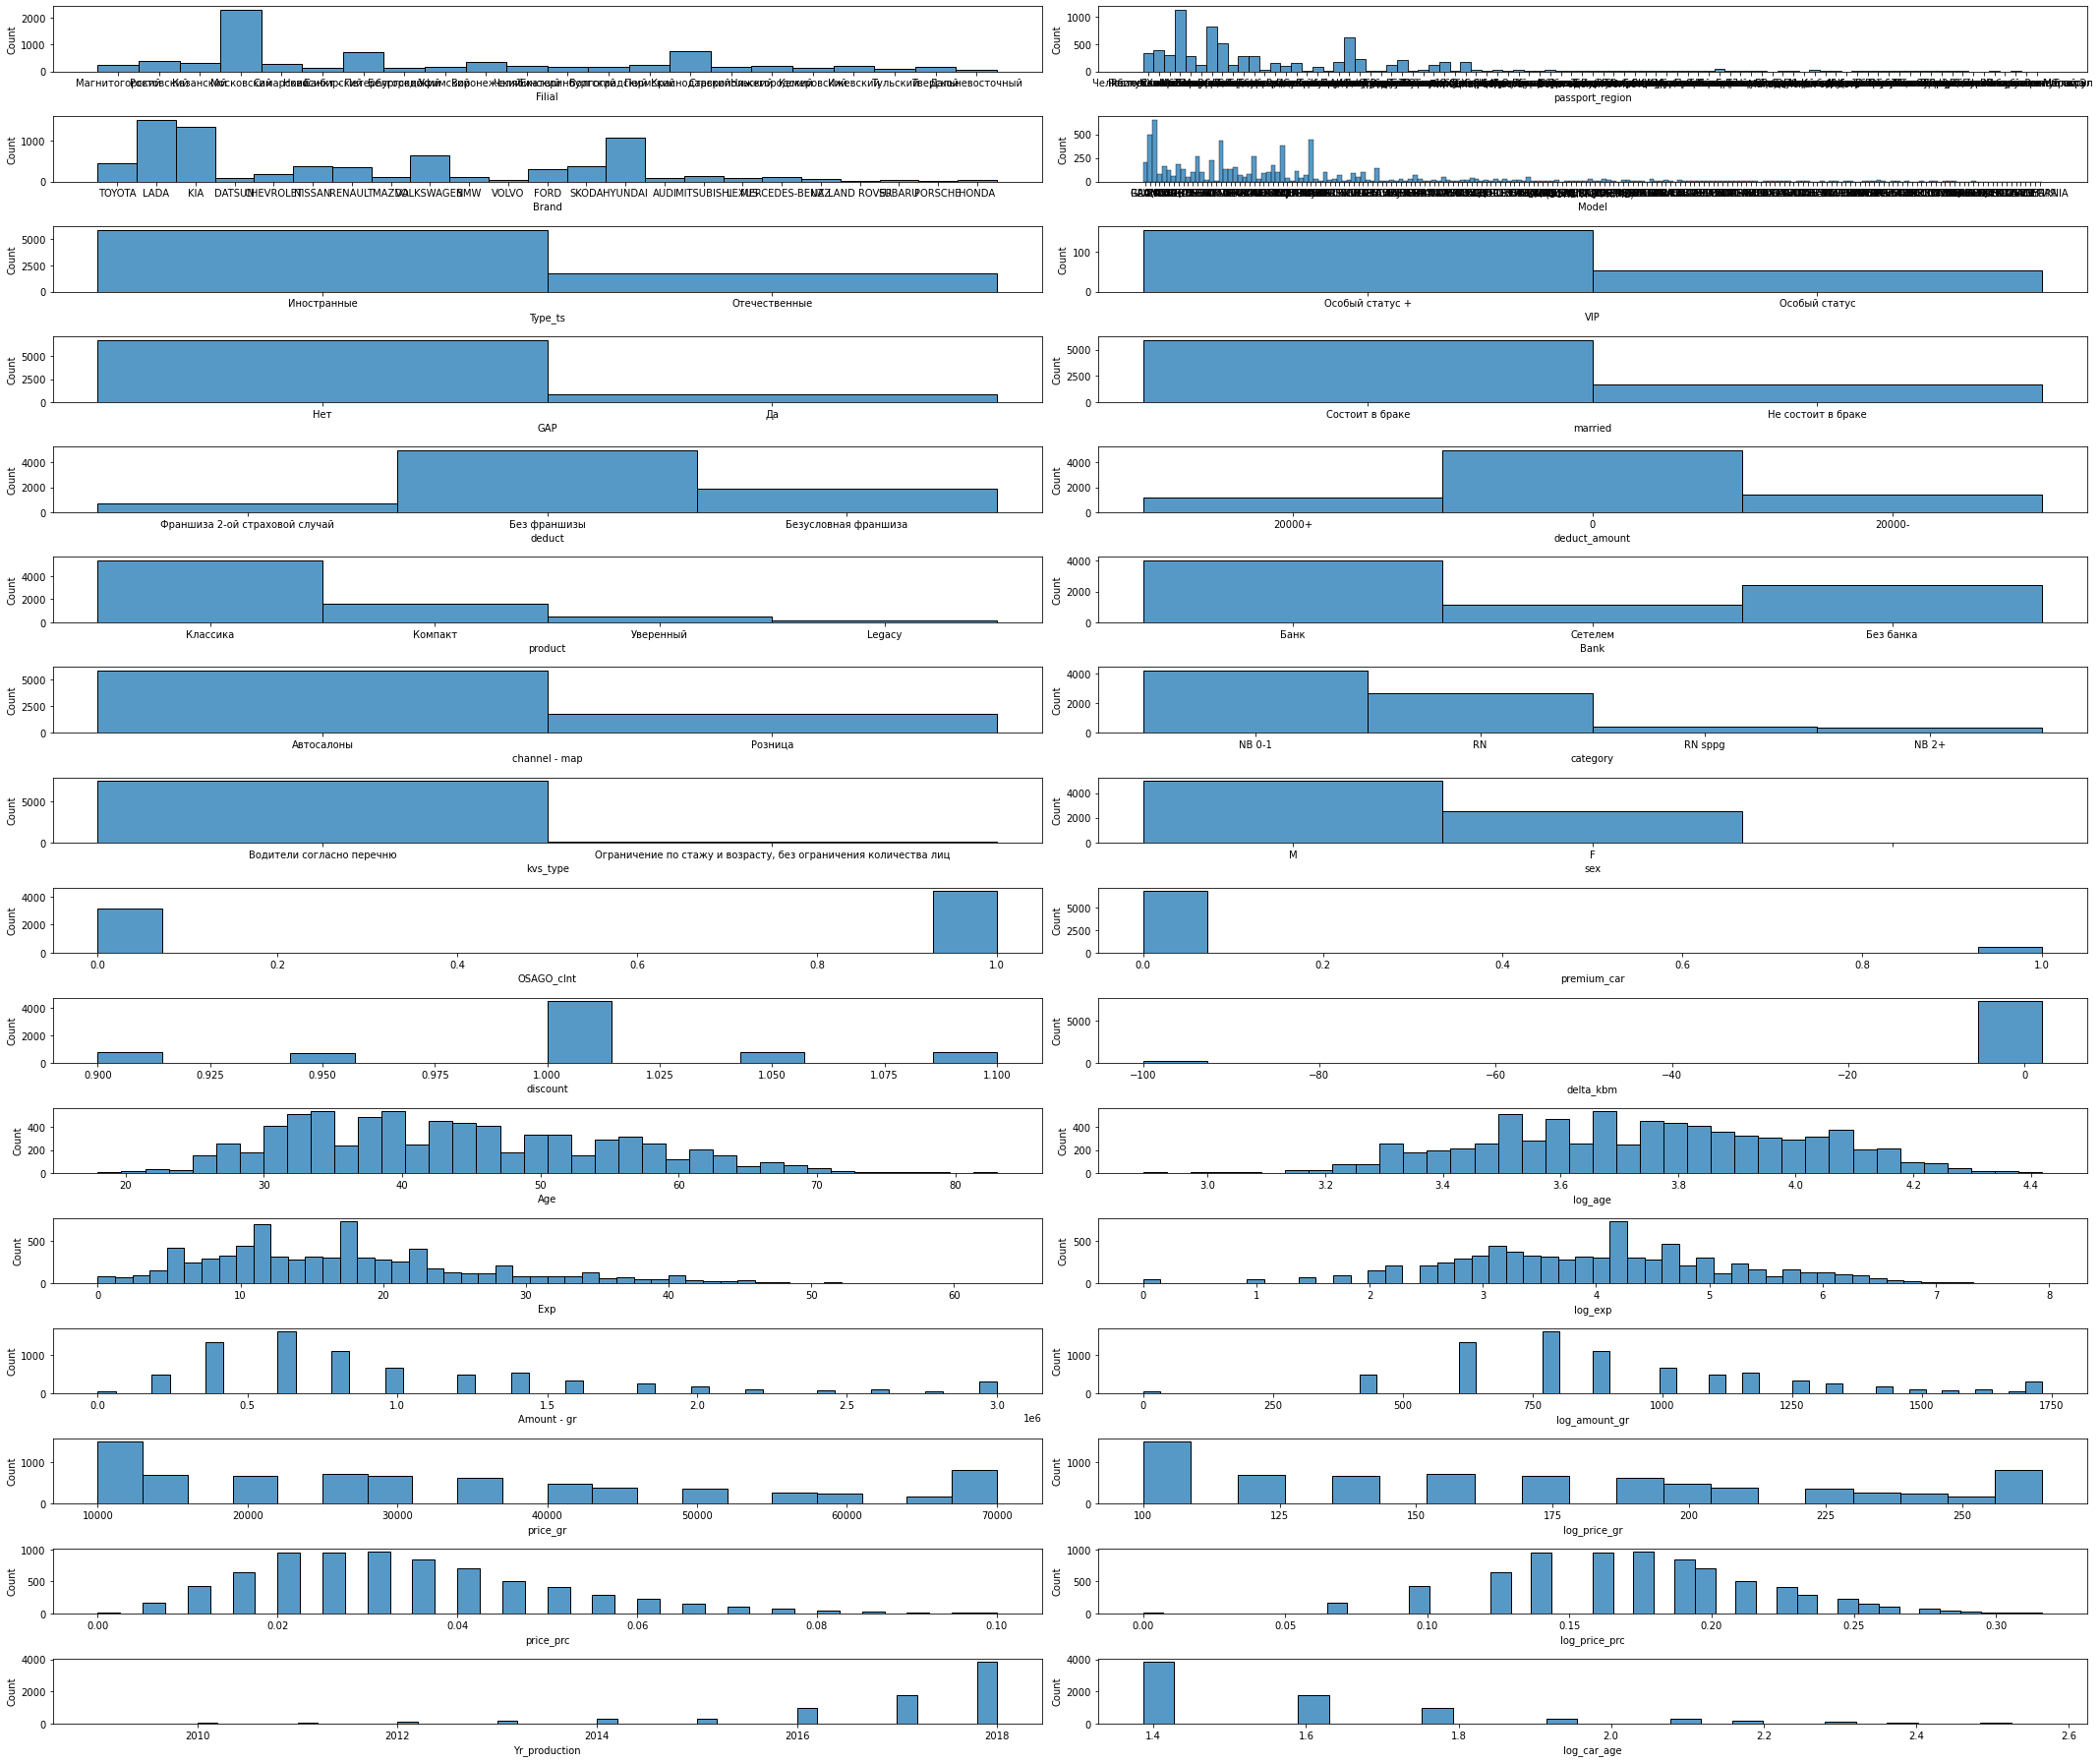

In [126]:
# Гистограммы
hist_features = ['Filial', 'passport_region', 'Brand', 'Model', 'Type_ts', 'VIP', 'GAP',\
 'married', 'deduct', 'deduct_amount', 'product','Bank','channel - map','category','kvs_type', 'sex',\
                'OSAGO_clnt', 'premium_car', 'discount', 'delta_kbm', 'Age', 'log_age',  'Exp', 'log_exp', 'Amount - gr', 'log_amount_gr', 'price_gr',\
           'log_price_gr', 'price_prc', 'log_price_prc','Yr_production','log_car_age', 'KBM', 'KBM_prol_est'] # 28
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(30,25))
for i in range(16):
    for j in range(2):
        if 2 * i + j == len(hist_features):
            break
        sns.histplot(df_train_temp[hist_features[2*i+j]], ax = axes[i,j])       
plt.tight_layout()

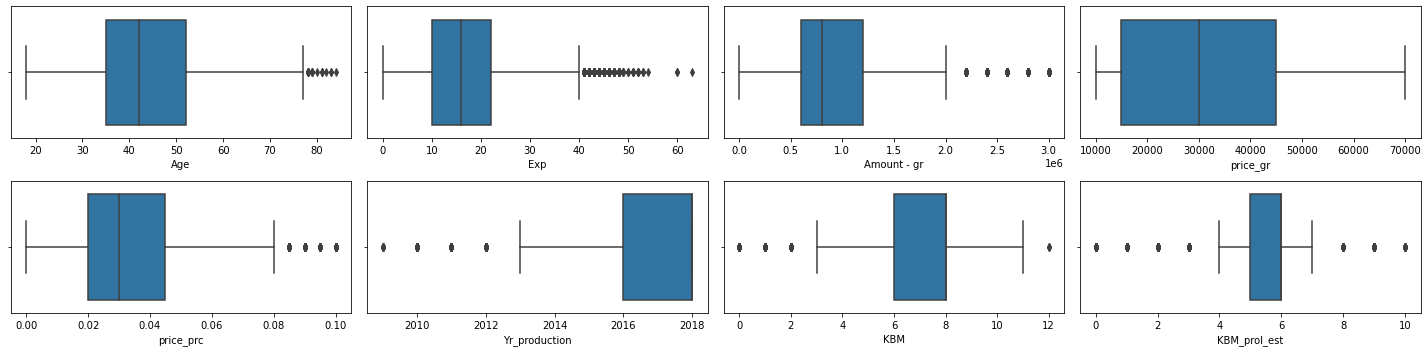

In [138]:
# боксплоты
numeric_features = ['Age', 'Exp', 'Amount - gr', 'price_gr', 'price_prc', 'Yr_production', 'KBM', 'KBM_prol_est'] # 8
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,5))
for i in range(2):
    for j in range(4):
        if 2 * i + j == len(numeric_features):
            break
        sns.boxplot(df[numeric_features[4 * i + j]], ax = axes[i,j])       
plt.tight_layout()

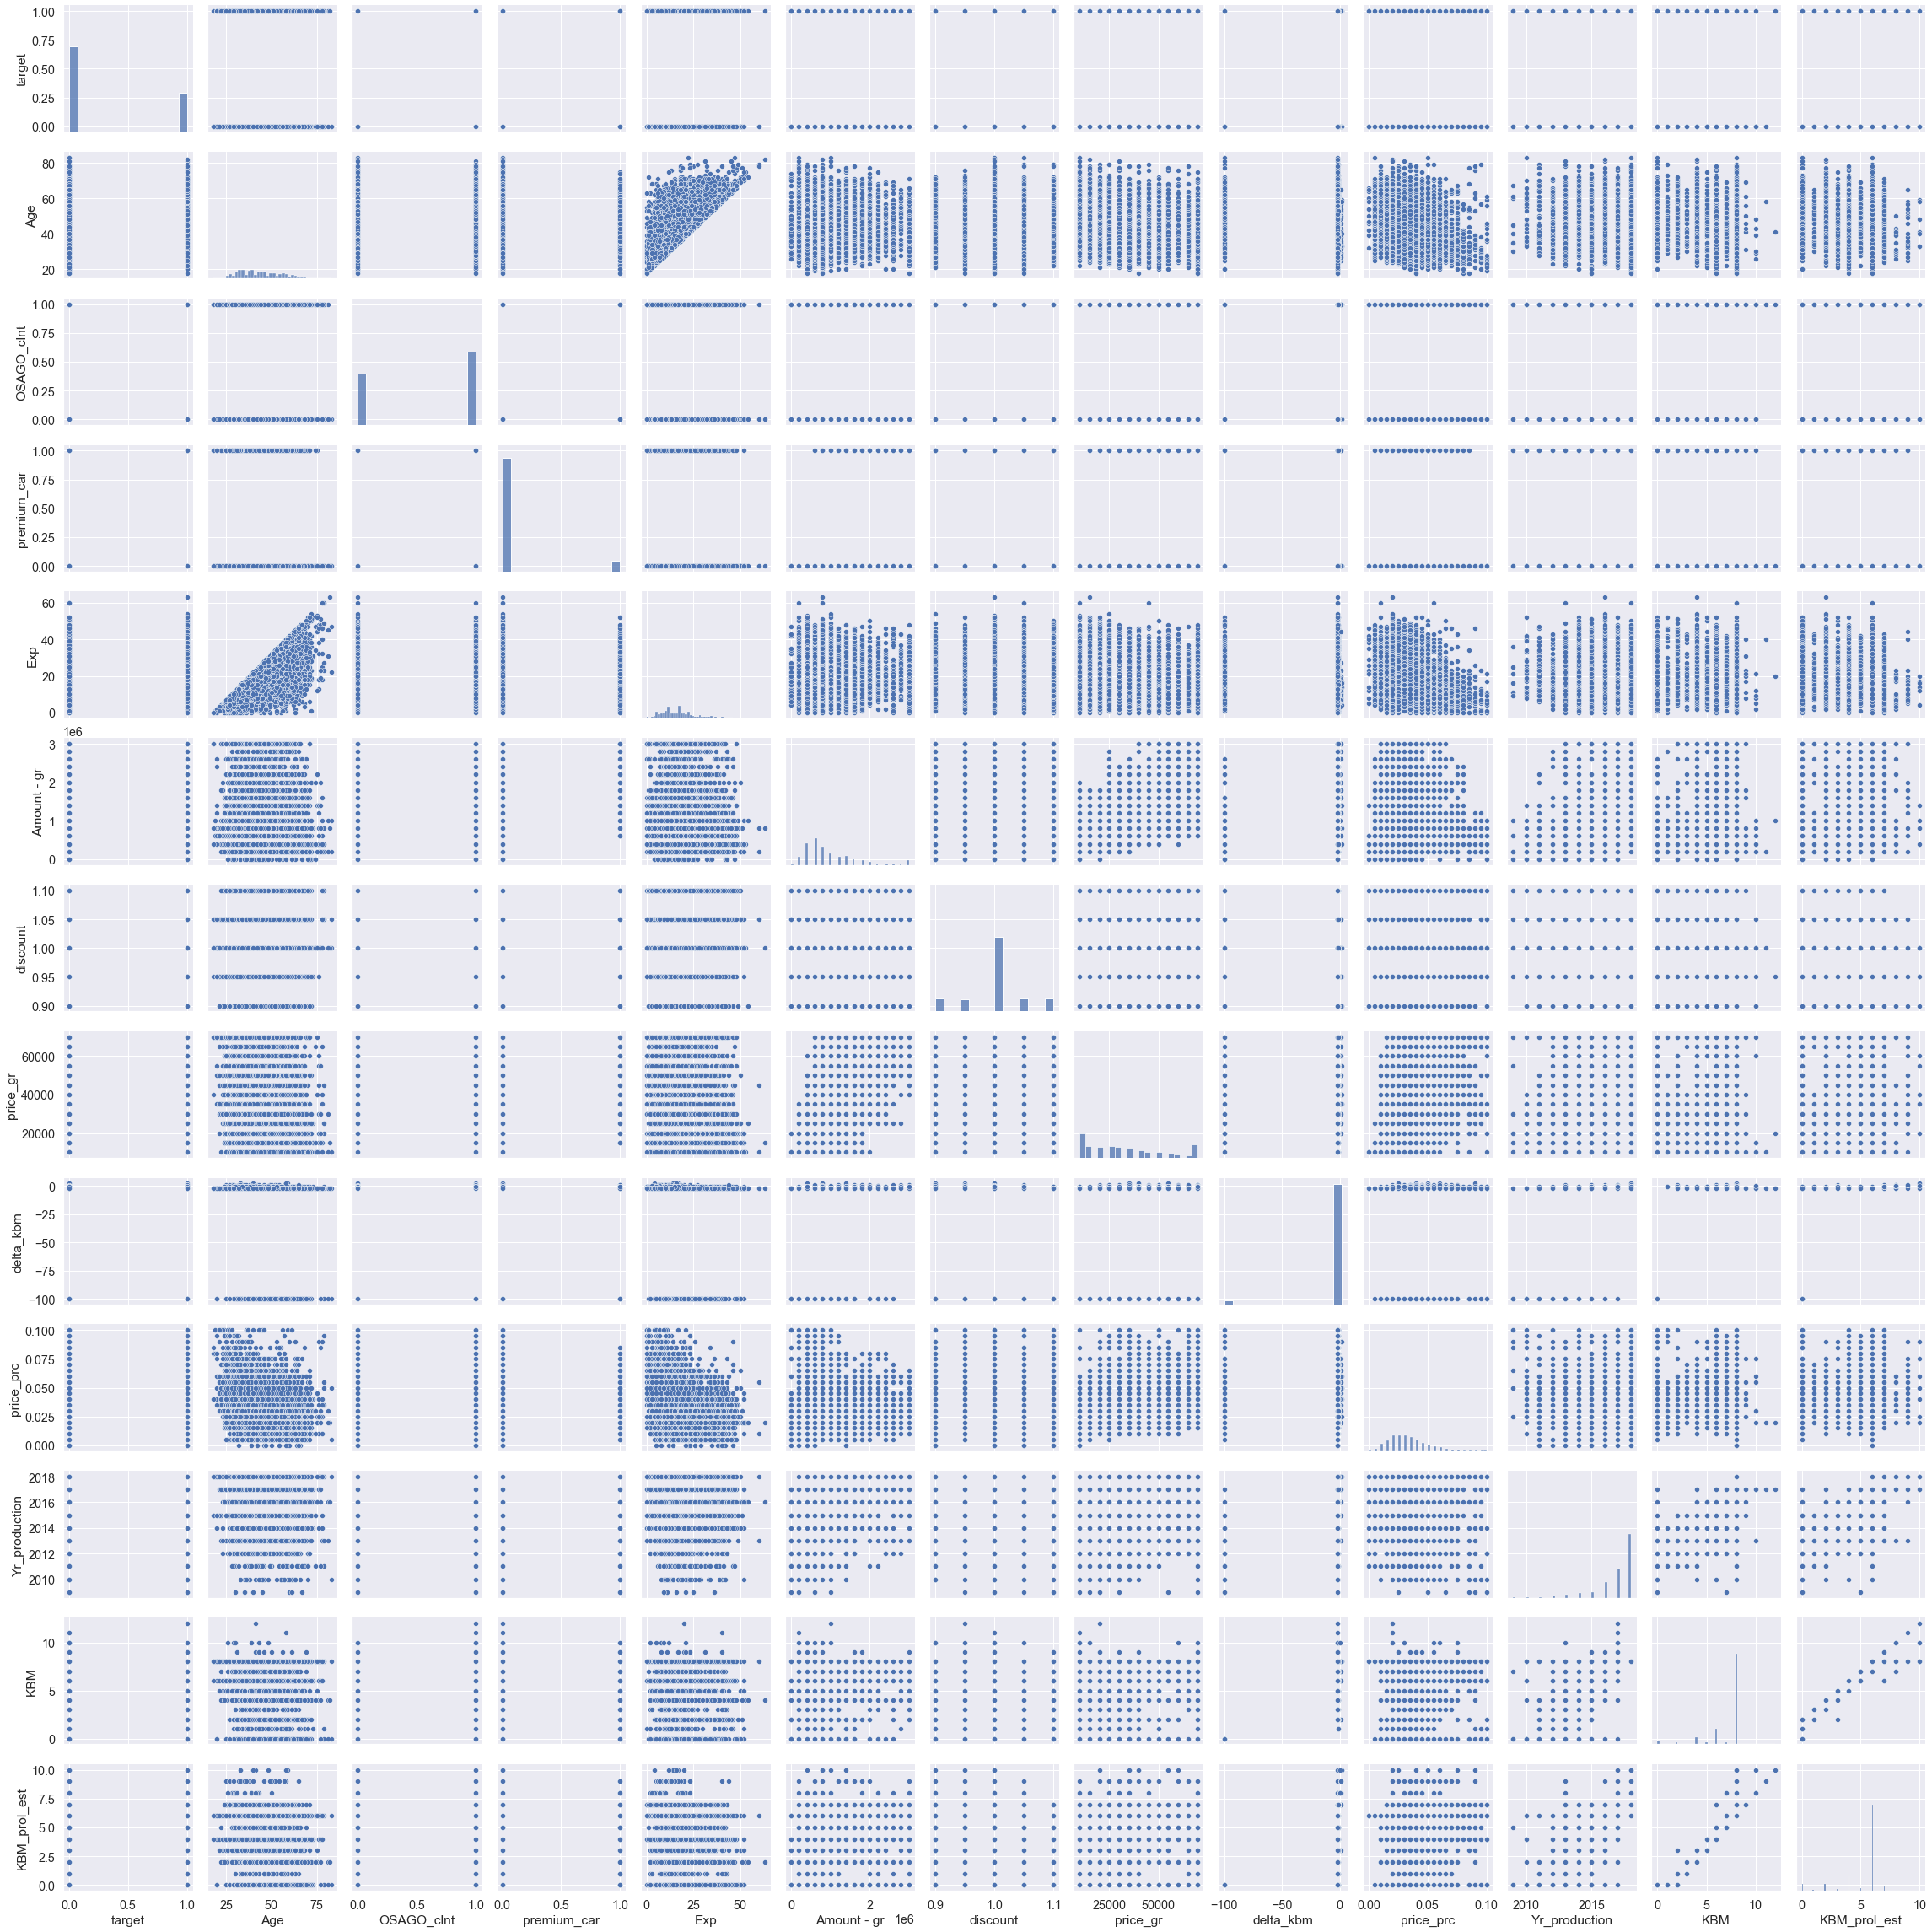

In [320]:
numeric = ['target', 'Age', 'OSAGO_clnt', 'premium_car', 'Exp', 'Amount - gr', 'discount', 'price_gr',\
          'delta_kbm', 'price_prc', 'Yr_production', 'KBM', 'KBM_prol_est']
sns.pairplot(df_train_temp[numeric]);

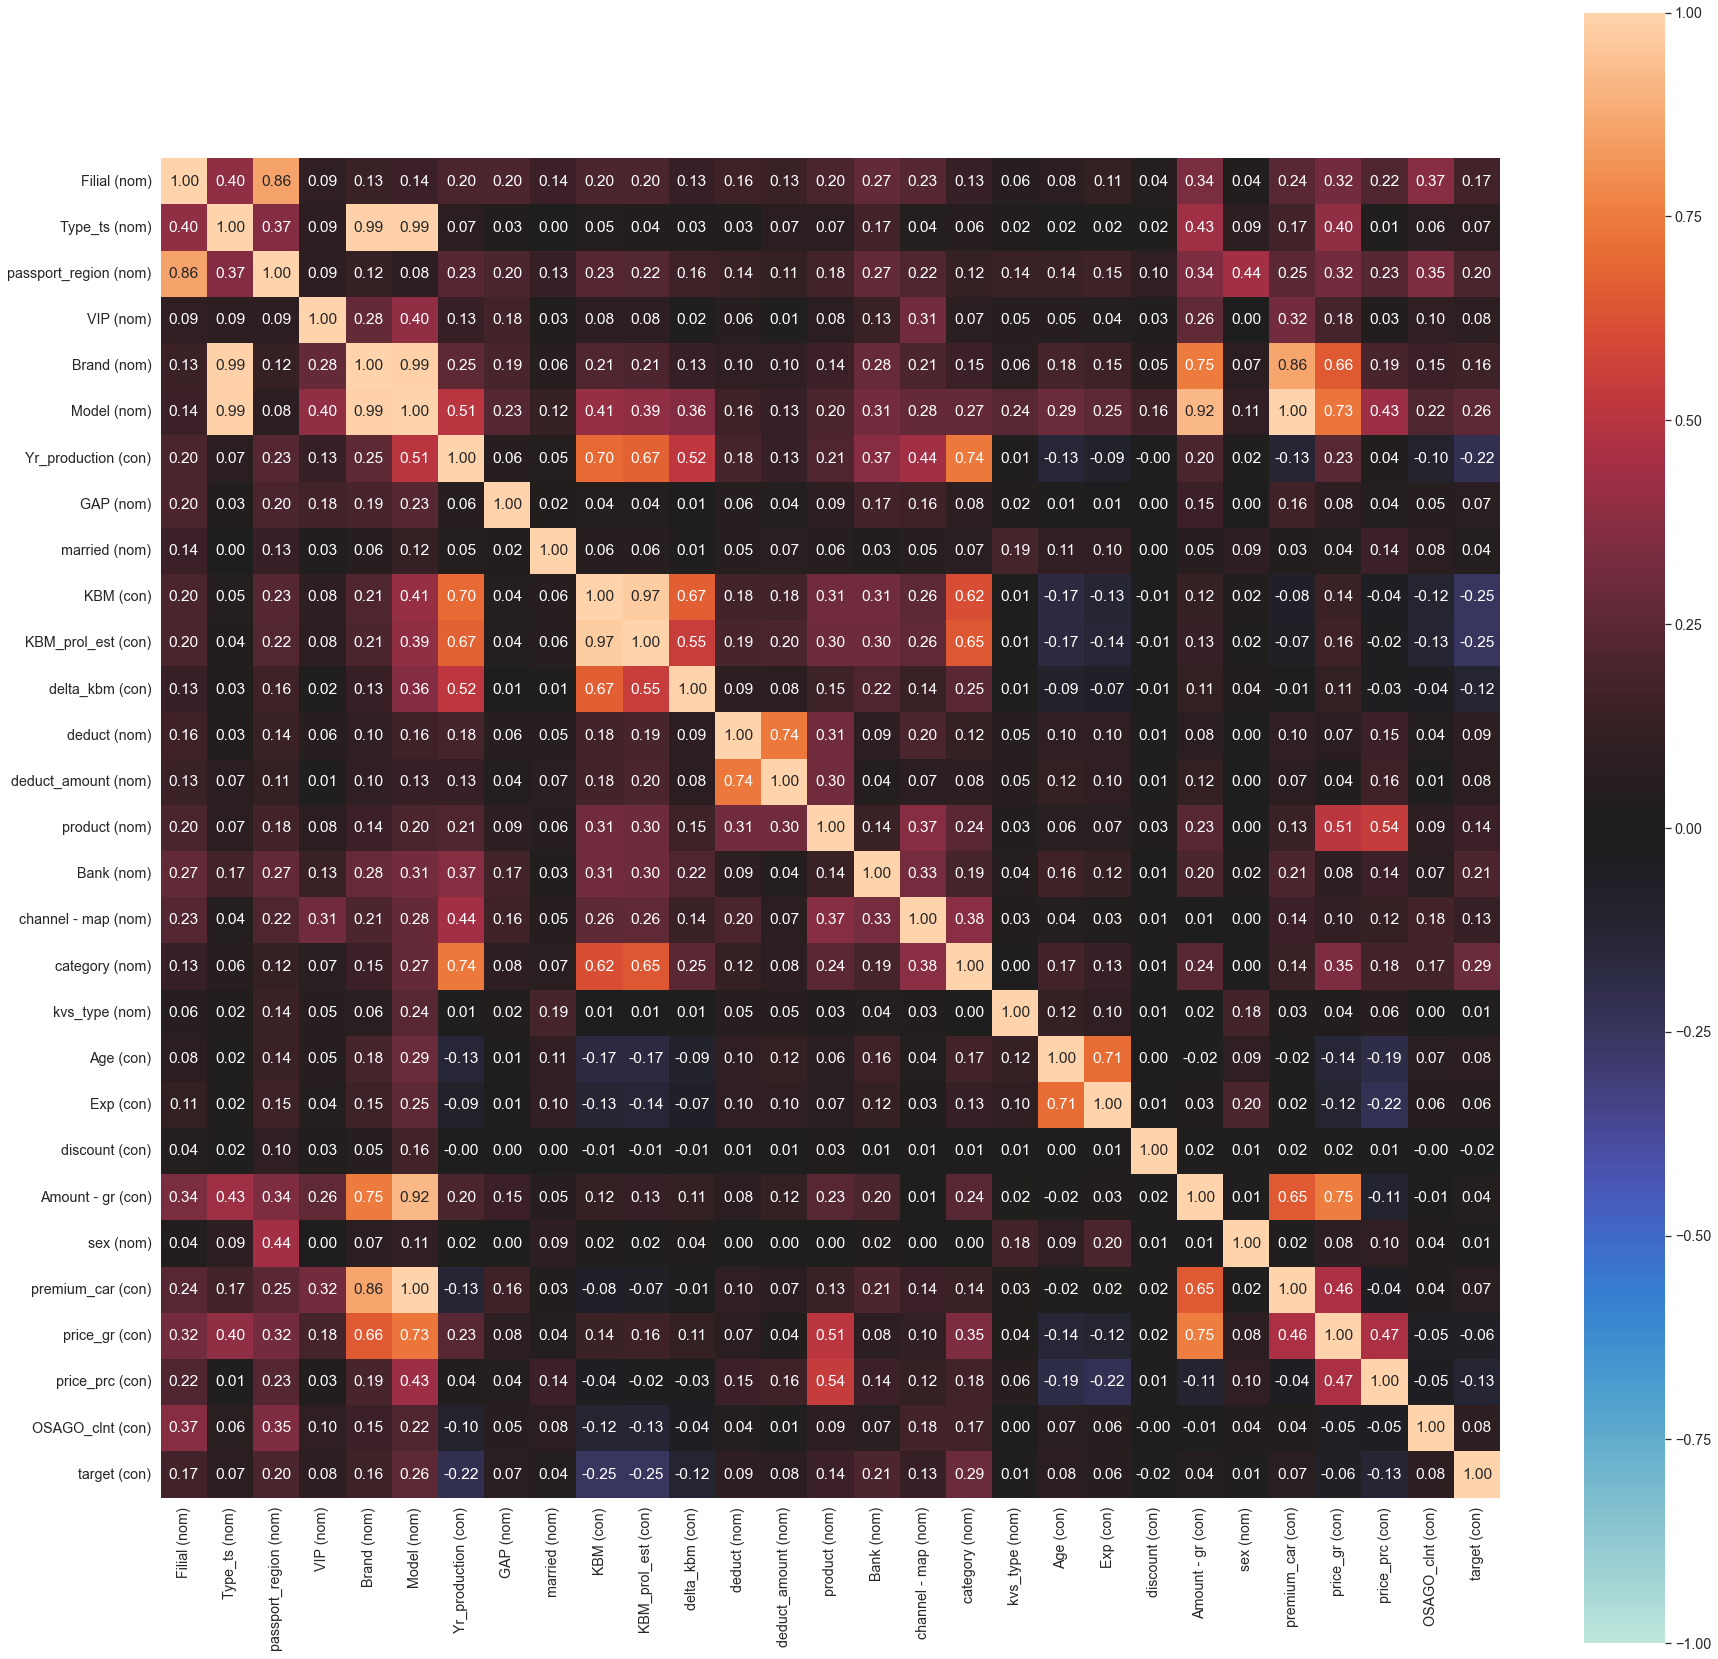

In [146]:
nominal.associations(df_train_temp,figsize=(30,30),mark_columns=True);

#### Посмотрим отдельные столбцы между собой

In [202]:
#Модели, бренды и метка импорта
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_train_temp[df_train_temp['Brand']=='CHEVROLET'][['Brand','Model','Type_ts']].value_counts())

Brand      Model    Type_ts      
CHEVROLET  NIVA     Отечественные    165
           CAPTIVA  Иностранные        7
           AVEO     Иностранные        5
           CRUZE    Иностранные        4
           ORLANDO  Иностранные        4
           TAHOE    Иностранные        3
           LACETTI  Иностранные        1
dtype: int64


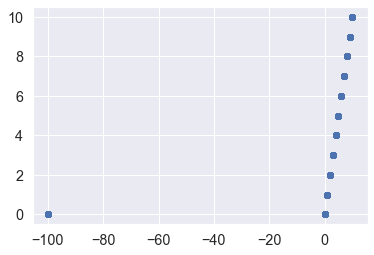

In [203]:
# KBM и производные 
plt.scatter((df_train_temp['KBM'] + df_train_temp['delta_kbm']), df_train_temp['KBM_prol_est'])

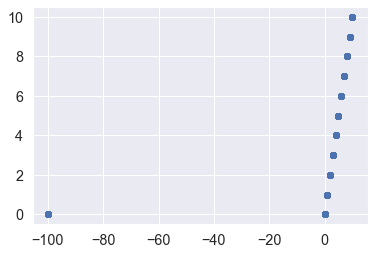

In [286]:
plt.scatter((df['KBM'] + df['delta_kbm']), df['KBM_prol_est'])

In [189]:
df_train_temp[df_train_temp['delta_kbm'] == -100][['KBM','KBM_prol_est', 'target']].value_counts()

KBM  KBM_prol_est  target
0    0             1         152
                   0          91
dtype: int64

In [199]:
# Франшиза
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_train_temp[['deduct','deduct_amount']].value_counts())

deduct                          deduct_amount
Без франшизы                    0                5006
Безусловная франшиза            20000+           1018
                                20000-            839
Франшиза 2-ой страховой случай  20000-            552
                                20000+            161
dtype: int64


#### Катбуст (чтобы посмотреть результат и feature importances)

In [139]:
cat_features = ['Filial', 'passport_region', 'VIP', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank', 'channel - map', 'category',
       'kvs_type', 'discount', 'sex', 'OSAGO_clnt', 'Brand', 'premium_car']
for i in cat_features:
    df[i] = [str(i) for i in df[i]]

In [140]:
df_train = df[df['target'] != -1].copy()
df_test = df[df['target'] == -1].copy()

In [143]:
df_train = df_train.drop(['Brand', 'Type_ts','delta_kbm'], axis=1)

In [149]:
for i in df_train[['Filial', 'passport_region', 'VIP', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank', 'channel - map', 'category',
        'discount', 'sex', 'OSAGO_clnt', 'premium_car']]:
    df_train[i] = [str(i) for i in df_train[i]]

In [150]:
# разбиваем на трейн и тест
x_train, x_valid, y_train, y_valid = train_test_split(df_train.drop(['target'],axis=1), df_train['target'], 
                                                      random_state=45, test_size=0.2)

In [154]:
cb = CatBoostClassifier(iterations=500, learning_rate = 0.1, random_seed = 43,
                         logging_level =  'Silent', l2_leaf_reg = 50, depth = 5, rsm = .5, one_hot_max_size = 8,
                         random_strength = 9, bagging_temperature = 20, eval_metric = 'AUC', )    
pool_train = Pool(x_train, y_train,
                  cat_features = ['Filial', 'passport_region', 'VIP', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank', 'channel - map', 'category','kvs_type',
        'discount', 'sex', 'OSAGO_clnt', 'premium_car'])
pool_valid = Pool(x_valid, y_valid,
                  cat_features = ['Filial', 'passport_region', 'VIP', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank', 'channel - map', 'category','kvs_type',
        'discount', 'sex', 'OSAGO_clnt', 'premium_car'])
cb.fit(pool_train, verbose=False, plot=True, eval_set=pool_valid, )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

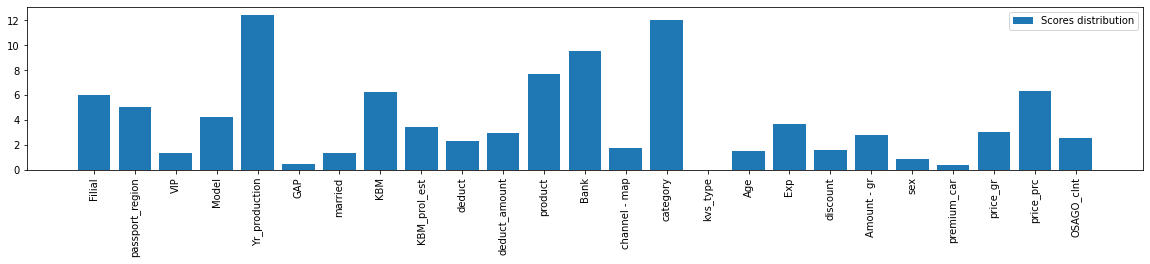

In [155]:
fig=plt.figure(figsize=(20,3))
a = np.arange(len(df_train.drop(['target'],axis=1).columns))
arguments = df_train.drop(['target'],axis=1).columns.to_list()
plt.xticks(labels = arguments, ticks = a, rotation = 90)
plt.bar(arguments,cb.feature_importances_,
        label='Scores distribution')
plt.legend();

#### Преобразования

In [4]:
# Заполним марки в тесте, которых нет в трейне
df_train_temp= df[df['target'] != -1]
mlist = df_train_temp['Model'].to_list()
mlist_ = set([i for i in df['Model'] if i not in mlist])
models_dict = {'A4 ALLROAD':'A4', 2111:'2170', 1119: '2115', 'DOKKER':'DUSTER', 'AMAROK':'TIGUAN', \
'TRAILBLAZER':'CAPTIVA', 'L-200':'OUTLANDER', 'PANAMERA':'MACAN', 'PASSAT CC':'PASSAT', '7-СЕРИЯ':'6-СЕРИЯ'}
df['Model'] = [models_dict[i] if i in mlist_ else i for i in df['Model']]

In [5]:
# Заполним пустоты в 'Sex'
df['sex'].replace(' ', 'M', inplace=True)
df['sex'].iloc[46]='F'

In [6]:
#  Преобразование
df['log_price_prc'] = [np.sqrt(i) for i in df['price_prc']]
df['log_price_gr'] = [np.sqrt(i) for i in df['price_gr']]
df['log_age'] = [np.log(i) for i in df['Age']]
df['log_amount_gr'] = [np.sqrt(i) for i in df['Amount - gr']]
df['log_exp'] = [np.sqrt(i) for i in df['Exp']]
df['log_car_age'] = [np.log(2022-i) for i in df['Yr_production']]

In [7]:
# Удалить лишнее : brand, premium_car, type_ts, delta_kbm, то что преобразовали
df = df.drop(['Brand', 'premium_car', 'Type_ts', 'delta_kbm', 'Yr_production', 'price_prc', 'Age', 'Amount - gr', \
              'Exp', 'price_gr','kvs_type'], axis = 1)

In [8]:
df.fillna('NONE', inplace=True)

In [9]:
#OneHotEncoding
df = pd.get_dummies(data = df, columns=['VIP', 'deduct', 'deduct_amount', 'product', 'Bank', 'category', 'sex'])

In [10]:
#OrdinalEncoding
encoder = OrdinalEncoder()
df['GAP'] = encoder.fit_transform(df[['GAP']])
df['married'] = encoder.fit_transform(df[['married']])
df['channel - map'] = encoder.fit_transform(df[['channel - map']])
df['OSAGO_clnt'] = encoder.fit_transform(df[['OSAGO_clnt']])                                              
# df['premium_car'] = encoder.fit_transform(df[['premium_car']])       
# df['kvs_type'] = encoder.fit_transform(df[['kvs_type']])   

In [11]:
for i in df[['Model']]:
    df[i] = [str(i) for i in df[i]]

In [12]:
#Вместо TargetEncoding
df = pd.get_dummies(data = df, columns=['Filial', 'passport_region', 'Model'])

In [56]:
#TargetEncoding
# encoder = TargetEncoder(min_samples_leaf = 20, smoothing = 10)
# encoder.fit(df['Filial'], df['target'])
# df['Filial'] = encoder.transform(df['Filial'])
# encoder.fit(df['passport_region'], df['target'])
# df['passport_region'] = encoder.transform(df['passport_region'])
# encoder.fit(df['Model'], df['target'])
# df['Model'] = encoder.transform(df['Model'])

In [325]:
# # SCALERS
# mmscaler = StandardScaler()
# df[['Age','Exp','Amount - gr','discount','price_gr','price_prc','KBM','KBM_prol_est']]\
#     = mmscaler.fit_transform(df[['Age','Exp','Amount - gr','discount','price_gr','price_prc','KBM','KBM_prol_est']])

In [13]:
# SCALERS
mmscaler = MinMaxScaler()
df[['log_age','log_exp','log_amount_gr','discount','log_price_gr','log_price_prc','KBM','KBM_prol_est']]\
= mmscaler.fit_transform(df[['log_age','log_exp','log_amount_gr','discount','log_price_gr','log_price_prc','KBM','KBM_prol_est']])                                      

In [14]:
df_train = df[df['target'] != -1].copy()
df_test = df[df['target'] == -1].copy()

In [15]:
df_train.drop_duplicates(keep = 'first', inplace=True)

In [45]:
#Генерация семплов для баланса
smt = SMOTE()
X_sm, Y_sm = smt.fit_resample(df_train.drop(['target'],axis=1), df_train['target'])

#### Понижение размерности (не помогло)

In [64]:
pca = PCA(n_components=20) 
tsne = TSNE(n_components=3, perplexity=50)
X_pca = pca.fit_transform(X_sm)

In [65]:
X_tsne = tsne.fit_transform(X_sm)

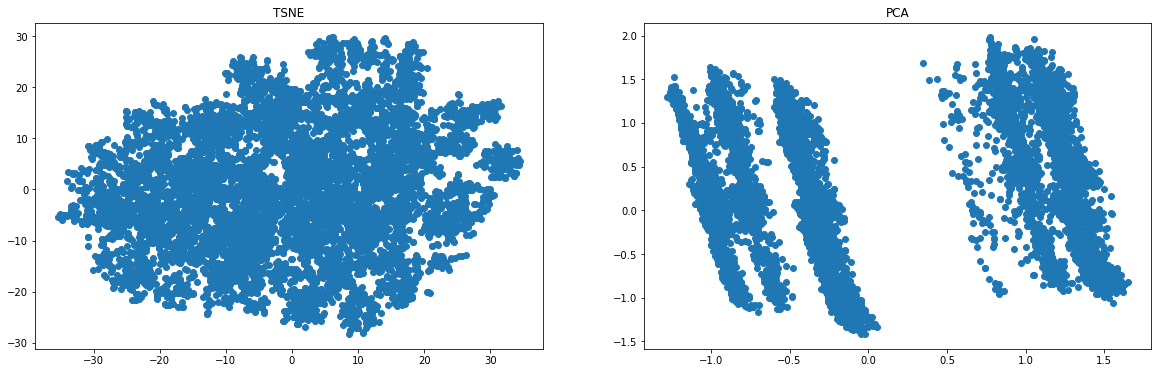

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax2.scatter(X_pca[:, 0], X_pca[:, 1])
ax1.set_title('TSNE')
ax2.set_title('PCA');

In [67]:
X = {
    'pca'  : X_pca,
    'tsne' : X_tsne,
}
models = {
    'KMeans' : KMeans(7),
    'AggCls' : AgglomerativeClustering(7),
    'DBSCAN' : DBSCAN(eps=0.6)
}

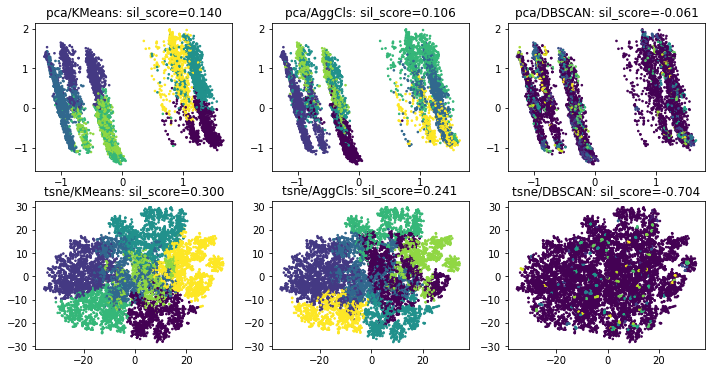

In [68]:
from sklearn.metrics import rand_score, jaccard_score, adjusted_mutual_info_score, silhouette_score
def plot_results(X: dict, models: dict):
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    for i in np.arange(2):
        for j in np.arange(3):
            X_ = list(X.values())[i]
            model = list(models.values())[j].fit(X_)
            colors = model.labels_
            sil_score = silhouette_score(X_, model.labels_)
#            
            ax[i, j].scatter(X_[:, 0], X_[:, 1], c=colors, cmap='viridis', marker='.', s=10)
            ax[i, j].set_title(f'{list(X.keys())[i]}/{list(models.keys())[j]}: sil_score={sil_score:.3f}')
plot_results(X, models)

In [95]:
ag = DBSCAN(eps=0.6)
ag_dbscan = ag.fit_predict(X_tsne)
X_sm['cluster'] = ag_dbscan
X_sm = pd.get_dummies(data = X_sm, columns=['cluster'])

#### Модели

In [16]:
# Без досемплирования
# X_sm, Y_sm = df_train.drop(['target'],axis=1), df_train['target']

In [96]:
# разбиваем на трейн и тест
x_train, x_valid, y_train, y_valid = train_test_split(X_sm, Y_sm, 
                                                      random_state=45, test_size=0.2)#, stratify = df_train['target'])

In [99]:
cll = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.3)
#cll = LogisticRegression(penalty = 'l2')
cll.fit(x_train, y_train.to_numpy().ravel())
y_pred_valid = cll.predict(x_valid)
y_pred_valid1 = cll.predict_proba(x_valid)[:,1]
scores_dict = {'LogisticRegression': roc_auc_score(y_valid, y_pred_valid1)}
df_scores = pd.DataFrame(scores_dict, index = ['roc_auc_score'])
roc_auc_score(y_valid, y_pred_valid1)

0.8743548785176037

In [98]:
cross_val_score(cll, x_train, y_train, cv=5, scoring='roc_auc')

array([0.87250295, 0.86320609, 0.86893308, 0.86517143, 0.86030816])

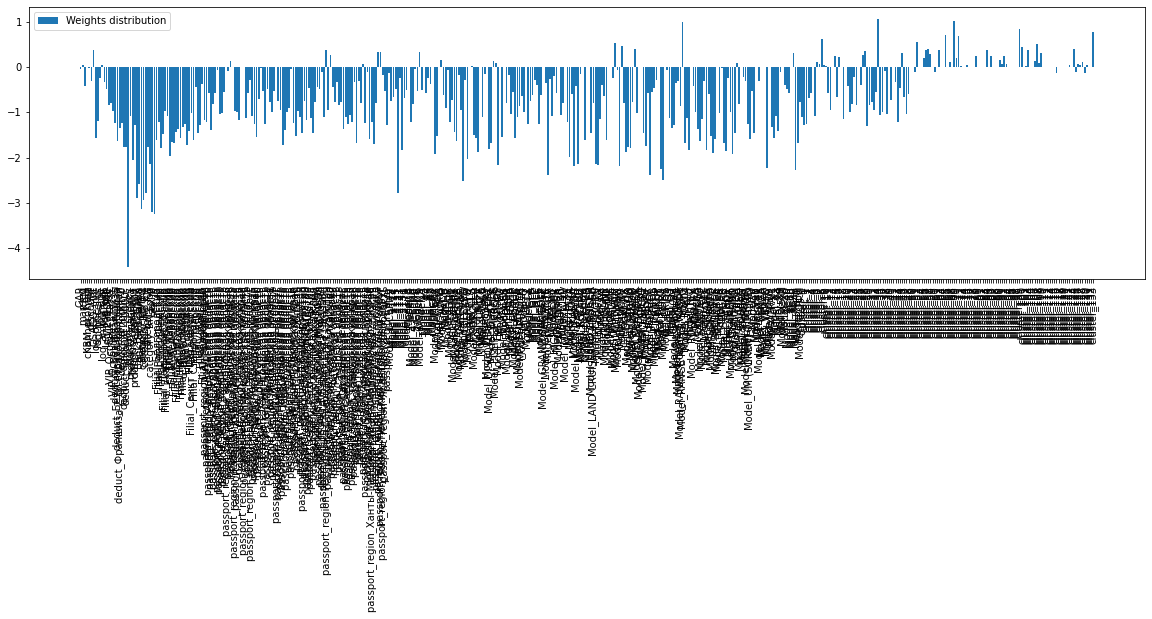

In [100]:
fig=plt.figure(figsize=(20,5))
a = np.arange(len(X_sm.columns))
arguments = X_sm.columns.to_list()
plt.xticks(labels = arguments, ticks = a, rotation = 90)
plt.bar(arguments, cll.coef_[0], label='Weights distribution')
plt.legend();

In [50]:
list_zeros = [i for i, j in zip(x_train.columns.to_list(), cll.coef_[0]) if j == 0 ]
list_zeros

['KBM_prol_est',
 'passport_region_Еврейская автономная область',
 'passport_region_Иркутская область',
 'passport_region_Камчатский край',
 'passport_region_Ненецкий автономный округ',
 'Model_3',
 'Model_A3',
 'Model_A7',
 'Model_AURIS',
 'Model_CLA',
 'Model_CLS',
 'Model_CRUZE',
 'Model_DISCOVERY',
 'Model_ECLIPSE CROSS',
 'Model_ED',
 'Model_ES',
 'Model_GETZ',
 'Model_GRAND SANTA FE',
 'Model_HUNTER',
 'Model_IMPREZA XV',
 'Model_KOLEOS',
 'Model_LACETTI',
 'Model_LANCER',
 'Model_ML',
 'Model_MOHAVE',
 'Model_OUTLANDER XL',
 'Model_PAJERO',
 'Model_PILOT',
 'Model_PRIUS',
 'Model_ROOMSTER',
 'Model_TOURAN',
 'Model_V90',
 'Model_VENGA',
 'Model_VENZA',
 'Model_VERSO',
 'Model_VITO',
 'Model_X5 M',
 'Model_XC70']

In [101]:
clr = LogisticRegression(max_iter=10000)
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'penalty': ['l1', 'l2', 'elasticnet'],
          'C':[0.01, 1, 5]
          }
grid_search_cv = GridSearchCV(clr, params, verbose=False, cv=5, scoring='roc_auc', n_jobs=5)
grid_search_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=5,
             param_grid={'C': [0.01, 1, 5],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc', verbose=False)

In [102]:
grid_search_cv.best_params_

{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}

In [103]:
y_pred_valid = grid_search_cv.best_estimator_.predict_proba(x_valid)
roc_auc_score(y_valid, y_pred_valid[:,1])
df_scores['LogisticRegression_GS'] = roc_auc_score(y_valid, y_pred_valid[:,1])

In [54]:
cb = CatBoostClassifier(iterations=1200, learning_rate = 0.1, random_seed = 43,
                         logging_level =  'Silent', l2_leaf_reg = 50, depth = 5, rsm = .5, one_hot_max_size = 8,
                         random_strength = 9, bagging_temperature = 20, eval_metric = 'AUC', )    
cb.fit(x_train, y_train, verbose=False, plot=True, eval_set=(x_valid, y_valid), )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [105]:
df_scores['CatBoost'] = roc_auc_score(y_valid, cb.predict_proba(x_valid)[:,1])

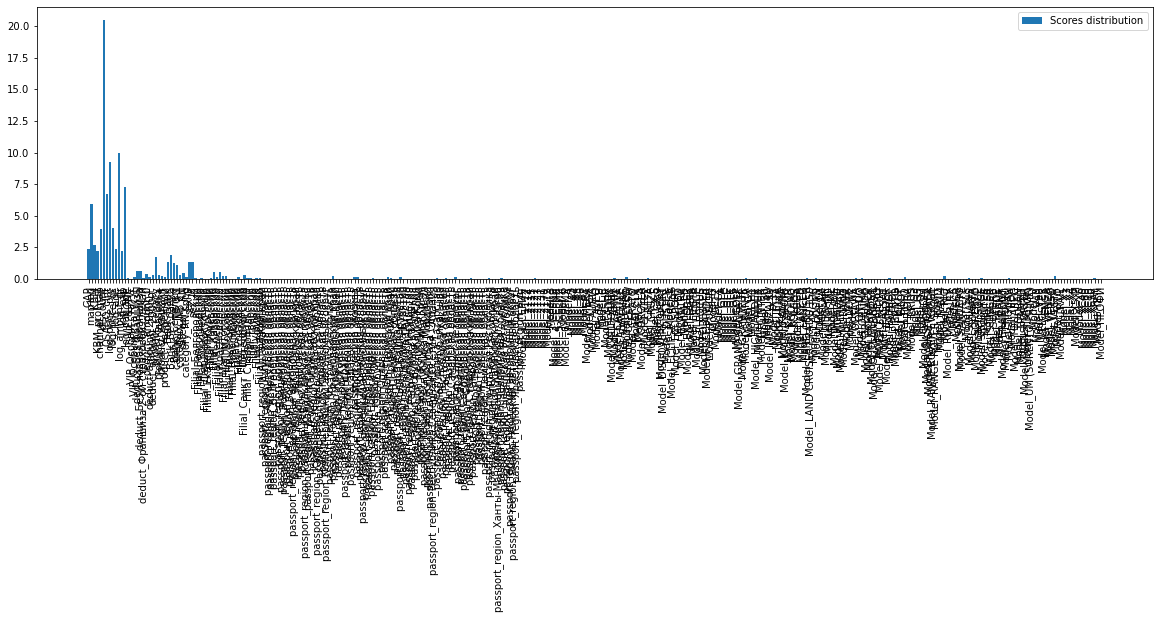

In [55]:
fig=plt.figure(figsize=(20,5))
a = np.arange(len(X_sm.columns))
arguments = X_sm.columns.to_list()
plt.xticks(labels = arguments, ticks = a, rotation = 90)
plt.bar(arguments,cb.feature_importances_,
        label='Scores distribution')
plt.legend();

In [205]:
#Распечатаем ошибки
# mist = pd.DataFrame(abs(y_pred_valid - y_valid) == 1).reset_index().rename(columns = {'index':'ID'})
# mist[mist['target']==True].merge(df_train, how = 'left', on = 'ID')

In [107]:
clvm = SVC(probability=True)
clvm.fit(x_train, y_train.to_numpy().ravel())
y_pred_valid = clvm.predict_proba(x_valid)
df_scores['SVM'] = roc_auc_score(y_valid, clvm.predict_proba(x_valid)[:,1])
roc_auc_score(y_valid, y_pred_valid[:,1])

0.8805365759222541

In [108]:
clrf1 = DecisionTreeClassifier()
params = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [11, 20, 23, 25, 27, 30, 32, 33, 35], 
    'min_samples_leaf': [5, 10, 29, 30, 31]
}
cv = GridSearchCV(clrf1, param_grid=params, scoring='roc_auc', cv=5, 
                  n_jobs=4)
cv.fit(x_train, y_train.ravel())
print(cv.best_estimator_, cv.best_score_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=32) 0.8142331360946876


In [112]:
y_pred_valid = cv.best_estimator_.predict_proba(x_valid)
df_scores['DTree'] = roc_auc_score(y_valid, y_pred_valid[:,1])
roc_auc_score(y_valid, y_pred_valid[:,1])

0.82580366653791

In [111]:
# Voting linear reg + tree
y_v = (cv.best_estimator_.predict_proba(x_valid)[:,1] + cll.predict_proba(x_valid)[:,1])/2
df_scores['Voting'] = roc_auc_score(y_valid,y_v)
roc_auc_score(y_valid, y_v)

0.8797332993244402

In [114]:
# Результаты различных моделей
df_scores

,LogisticRegression,LogisticRegression_GS,CatBoost,SVM,DTree,Voting
roc_auc_score,0.874355,0.87726,0.892028,0.880537,0.825804,0.879733


#### Предсказание

In [231]:
df_test['Predict'] = clvm.predict(df_test.drop(['target'], axis=1))